## Believing cojunctions - simulation

Setting parameters:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

THRESHOLD = 0.5
MAX_CONJUNCTS = 4
CONJUNCTIONS_NR = 10000  # number of conjunctions
BELIEFS_NR = 1000000  # number of believed propositions
LEVELS_NR = [1001, 101, 51, 21, 15, 11, 9, 7, 5]  # simulated number of levels

In [2]:
def round_to_lev(value, nr):
    """
    Rounds 'value' according to the 0-1 scale with 'nr' of levels
    :param value: real number to be rounded
    :param nr: nr of levels used for calculations
    :returns: rounded value
    """
    if nr == 1001:
        return round(value, 3)
    if nr == 101:
        return round(value, 2)
    if value == 1:
        return 1
    if value == 0:
        return 0
    diff = 1/(nr-2)
    err = 1
    level = diff/2
    result = 0
    for _ in range(nr-2):
        if abs(value-level) < err:
            err = abs(value-level)
            result = level
        level += diff
    return result

Creating random conjunctions out of propositions, counting those that are above the threshold and comparing the results for different accuracies.

In [3]:
def simulate(beliefs, levels=LEVELS_NR):
    """
    :param beliefs: list of degrees of belief for believed propositions, e.g. [0.79, 0.8, 0.64 ...]
    :param levels: simulated number of distinguished confidence levels
    :returns: tp, fp, tn, fn for each number of confidence levels
    """
    n = len(levels)  # number of simulations - each simulation for different amount of levels
    tp, fp, tn, fn = [0]*n, [0]*n, [0]*n, [0]*n  # lists with results
    for _ in range(CONJUNCTIONS_NR):
        c_size = np.random.randint(2, MAX_CONJUNCTS + 1)  # each conjunction has random amount of conjuncts - c_size
        conjuncts = np.random.randint(0, BELIEFS_NR, c_size)  # selecting propositions randomly
        conj_prob_round = [1]*n  # list of rounded probabilities of conjunctions for each number of levels
        conj_float = 1
        for conjunct in conjuncts:
            conj_float *= beliefs[conjunct]
            for levels_value in range(n):
                conj_prob_round[levels_value] *= round_to_lev(beliefs[conjunct], levels[levels_value])
        justified_float = conj_float > THRESHOLD
        for levels_value in range(n):
            conjunction_rounded = round_to_lev(conj_prob_round[levels_value], levels[levels_value])
            justified_rounded = conjunction_rounded > round_to_lev(THRESHOLD, levels[levels_value])
            if justified_rounded:
                if justified_float:
                    tp[levels_value] += 1
                else:
                    fp[levels_value] += 1
            else:
                if justified_float:
                    fn[levels_value] += 1
                else:
                    tn[levels_value] += 1
    return tp, fp, tn, fn

Performing simulation:

In [4]:
beliefs = np.random.random(BELIEFS_NR) * (1 - THRESHOLD) + THRESHOLD
tp, fp, tn, fn = simulate(beliefs)

Printing results:

In [5]:
print("Threshold:", THRESHOLD)
print("Number of conjuncts: {}".format([n for n in range(2, MAX_CONJUNCTS+1)]))
print("All conjunctions:", CONJUNCTIONS_NR)
print("*********************************")
print("Results for different number of levels:")
results = []
for l in range(len(LEVELS_NR)):
    accuracy = (tp[l]+tn[l])/(tp[l]+fp[l]+tn[l]+fn[l])
    if tp[l]+fp[l] > 0:
        precision = tp[l]/(tp[l]+fp[l])
    else:
        precision = np.NaN
    if tp[l]+fn[l] > 0:
        recall = tp[l]/(tp[l]+fn[l])
    else:
        recall = np.NaN
    results.append([accuracy, precision, recall])   
results = pd.DataFrame(results, columns=["ACCURACY", "PRECISION", "RECALL"], index=LEVELS_NR)
print(results)
print("*********************************")
print("Confusion matrix:")
matrix = pd.DataFrame([tp, tn, fp, fn], columns=LEVELS_NR, index=['TP','TN','FP','FN']).transpose()
print(matrix)

Threshold: 0.5
Number of conjuncts: [2, 3, 4]
All conjunctions: 10000
*********************************
Results for different number of levels:
      ACCURACY  PRECISION    RECALL
1001    0.9989   1.000000  0.996577
101     0.9896   0.999358  0.968264
51      0.9796   0.999336  0.937150
21      0.9535   0.997827  0.857187
15      0.9269   0.997197  0.774736
11      0.9155   0.995814  0.740199
9       0.9010   0.987292  0.700996
7       0.8652   0.989507  0.586808
5       0.8172   0.970149  0.444928
*********************************
Confusion matrix:
        TP    TN  FP    FN
1001  3203  6786   0    11
101   3112  6784   2   102
51    3012  6784   2   202
21    2755  6780   6   459
15    2490  6779   7   724
11    2379  6776  10   835
9     2253  6757  29   961
7     1886  6766  20  1328
5     1430  6742  44  1784


Creating plots:

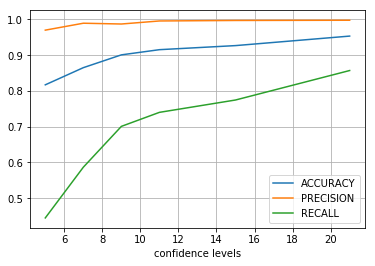

In [11]:
plt.plot(results[3:])
plt.grid(True)
plt.xlabel('confidence levels')
plt.legend(results.columns)
plt.savefig('metrics-small.png')
plt.show()


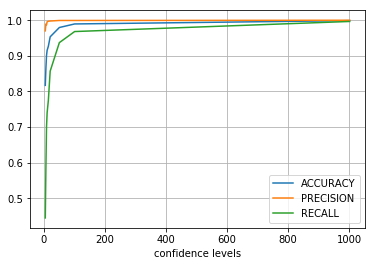

In [10]:
plt.plot(results)
plt.grid(True)
plt.xlabel('confidence levels')
plt.legend(results.columns)
plt.show()
plt.savefig('metrics-big.png')

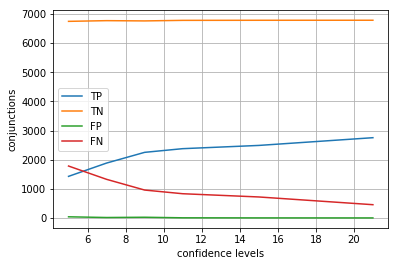

In [8]:
plt.plot(matrix[3:])
plt.grid(True)
plt.xlabel('confidence levels')
plt.ylabel('conjunctions')
plt.legend(matrix.columns)
plt.show()